# Materialmodelle mittels künstliche neuronale Netze

Information:
* Author: Dr.-Ing. Mauricio Fernández
* Zuletzt edited: 2021-12-05

Inhaltsverzeichnis
* [Daten](#Daten)
* [Datengetriebenes Modell](#Datengetriebenes-Modell)
    * [Modellarchitektur](#Modellarchitektur)
    * [Zielfunktion und Kalibrierung](#Zielfunktion-und-Kalibrierung)
    * [Modellauswertung](#Modellauswertung)
    * [Weiterführende Literatur](#Weiterführende-Literatur)

Benötigte Module

In [11]:
import numpy as np
import h5py as h5
import tensorflow as tf
import sys
sys.path.append('../files/modules/')
import material_model as mm

## Daten

Lade Daten von [Fritzen, Fernández and Larsson (2019)](https://www.frontiersin.org/articles/10.3389/fmats.2019.00075/full)

<img src="../files/figures/rve.png" width="400">

In [12]:
data = h5.File('../files/data/data.h5', 'r')
strain = data['training']['strain'][:4*9]
stress = data['training']['stress_FE'][:4*9]
data.close()

In [13]:
print(strain.shape)
print(stress.shape)

(36, 6)
(36, 6)


Dehnungs- und Spannungstensoren

$$
\varepsilon
=
\begin{pmatrix}
\varepsilon_{11} & \varepsilon_{12} & \varepsilon_{13} \\
& \varepsilon_{22} & \varepsilon_{23} \\
& & \varepsilon_{33} \\
\end{pmatrix}
\quad \rightarrow \quad
\varepsilon
=
(
\varepsilon_{11},
\varepsilon_{22},
\varepsilon_{33},
\sqrt{2}\varepsilon_{12},
\sqrt{2}\varepsilon_{13},
\sqrt{2}\varepsilon_{23},
)
$$

$$
\sigma
=
\begin{pmatrix}
\sigma_{11} & \sigma_{12} & \sigma_{13} \\
& \sigma_{22} & \sigma_{23} \\
& & \sigma_{33} \\
\end{pmatrix}
\quad \rightarrow \quad
\sigma
=
(
\sigma_{11},
\sigma_{22},
\sigma_{33},
\sqrt{2}\sigma_{12},
\sqrt{2}\sigma_{13},
\sqrt{2}\sigma_{23},
)
$$

Darstellung der 4 Deformationspfade (9 Punkte pro Pfad).

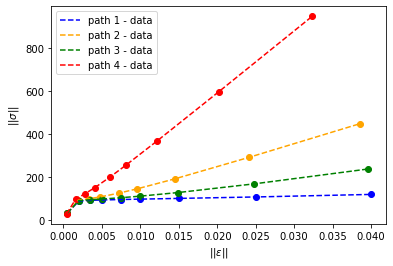

In [14]:
mm.plot_strain_stress(strain, stress)

## Datengetriebenes Modell

### Modellarchitektur

Netzwerk mit Eingang $x \in \mathbb{R}^3$ und Ausgang $f(x) \in \mathbb{R}^2$ mit 3 Schichten (2 versteckte Schichten + 1 Ausschicht)

<img src="../files/figures/ann.png" width="400" align="left">

<img src="../files/figures/activation.png" width="350" align="left">

Transformation zu normalisierten Eingang

In [15]:
mu = np.mean(strain, 0)
sig = np.std(strain, 0)
x = (strain - mu)/sig
f = stress

Digitaler Zwilling: künstliches neuronales Netz (KNN) für Eingang $x \in \mathbb{R}^6$ und mit Ausgang $f(x) \in \mathbb{R}^6$

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, 'softplus', input_shape=[6])
    ,tf.keras.layers.Dense(8, 'softplus')
    ,tf.keras.layers.Dense(6)
    ])

model.summary()

model.compile('adam', 'mse')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 56        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 54        
Total params: 182
Trainable params: 182
Non-trainable params: 0
_________________________________________________________________


### Zielfunktion und Kalibrierung

Mittlerer quadratischer Fehler (mse = mean squared error) vor der Kalibrierung.

In [17]:
model.evaluate(x, f)

2/2 [==============================] - 0s 0s/step - loss: 10099.4463


10099.4462890625

Kalibrierung mithilfe gegebener Daten (Minimierung vom mittleren quadratischen Fehler)

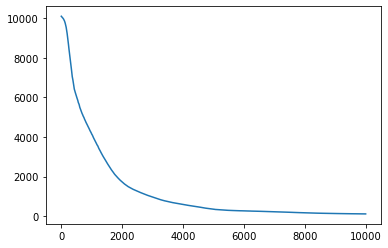

In [18]:
h = model.fit(x, f, epochs=10000, verbose=0)
mm.plot_loss(h)

Mittlerer quadratischer Fehler nach der Kalibrierung

In [19]:
model.evaluate(x, f)

2/2 [==============================] - 0s 1ms/step - loss: 115.9299


115.92987823486328

### Modellauswertung

Auswertung vom kalibrierten Model

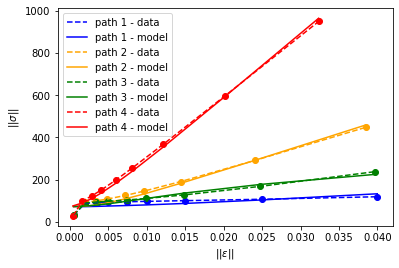

In [20]:
stress_model = model.predict((strain - mu)/sig)
mm.plot_strain_stress(strain, stress, stress_model)

### Weiterführende Literatur

Model (digitaler Zwilling der Mikrostruktur) einsetzbar in Bauteilsimulationen für bspw. Formoptimierung.

<img src="../files/figures/problem.png" width="500">

Fortgeschrittenes Modell mit adaptivem Modelwechsel, siehe [Fritzen, Fernández and Larsson (2019)](https://www.frontiersin.org/articles/10.3389/fmats.2019.00075/full)